## Roll number: 2023122002


### Instructions
 * Fill in the roll-number in the cell above.
 * Code must be submitted in Python in jupyter notebooks. We highly recommend using anaconda/miniconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * For this assignment, you will be using Open3D  extensively. Refer to [Open3D](http://www.open3d.org/docs/release/) documentation.
 *  Most of the questions require you to **code your own functions** unless there is a need to call in the abilities of the mentioned libraries, such as Visualisation from Open3D. Make sure your code is modular since you will be reusing them for future assignments. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 *  All the representations are expected to be in a right-hand coordinate system.
<!--  * Answer to the descriptive questions should be answered in your own words. Copy-paste answers will lead to penalty. -->
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit the notebooks in the repo and any other results files under the result folder in the GitHub Classroom repo. 
 * Commits past the deadline will not be considered.
 * This is a group assignment. Discussions are encouraged but any sharing of code among different teams will be penalized. 

### Instructions for group formation
 * We have circulated google sheet in moodle to fill in team members. Please finalize the teams formation by 18th Aug (tentative deadline). Same teams will be working towards project and other 2 Assignments as well. 
 


# Q1: Transformations and Projections on Autonomous Driving Dataset (20 Points)

In this question, you will work with real world autonomous driving dataset (sequence in Waymo dataset). The dataset has LiDAR point clouds, images. You are required to demonstrate: 

**I. Various transformations of rotation matrices as described in below tasks.**

**II. Visualization as a result of above transformations in Open3D**

## Given data:

1.) `LiDAR Point Clouds` : Stored at each timestep in the folder `lidar`. The point clouds are provided in the ego frame attached to lidar sensor (vehicle's reference frame).

2.) `Images` : Stored at each timestep in the folder `images`. 

**Naming Convention** : {timestep}_{cam_no}.jpg where timestep is specified in 3 digits and cam_no : [0, 1, 2] indicates centre, left and right camera respectively.

3.) `Camera-to-Ego Transformations`: Stored in the folder `cam2ego`, which converts points from each camera's reference frame to the vehicle's (or ego) reference frame.

4.) `Ego-to-World Transformations`: Stored in the folder `ego2world`, which converts points from the vehicle's reference frame to the world frame W.

5.) `Camera Intrinsics`: Stored in the folder `intrinsics` provided for 3 cameras.




### Helper functions to read lidar data and camera instrinsics are provided below

Header Files 

In [1]:
import numpy as np
import open3d as o3d
import os 
import matplotlib.pyplot as plt
import cv2
from scipy.optimize import fsolve
import copy
import time


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
# Helper function to read instrinsic matrix
def read_intrinsic(timestep):
    intrinsic = np.loadtxt(f"sample_intrinsic_{timestep}.txt")
    fx, fy, cx, cy = intrinsic[0], intrinsic[1], intrinsic[2], intrinsic[3]
    intrinsic_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

read_intrinsic(1)   

In [3]:
# Helper function to read lidar data at timestep 0 (same logic to read lidars at all remaining timesteps)

lidar_data = np.memmap('sample_lidar_data_000.bin',
                dtype=np.float32,
                mode="r",
            ).reshape(-1, 14)   # (165454, 14)

lidar_origins = lidar_data[:, :3]
lidar_points = lidar_data[:, 3:6]   # (165454, 3)
lidar_ids = lidar_data[:, -1]   # (165454,)

# Lidar points to be used 
print(lidar_points.shape)
print(lidar_points[:3,:])
print(lidar_origins.shape)
print(lidar_origins[:3,:])
print(lidar_ids.shape)
print(lidar_ids[:3])

(165454, 3)
[[-65.95801     4.640503    5.0833435]
 [-66.268555   13.631836    5.147156 ]
 [-66.59082    13.86438     5.162674 ]]
(165454, 3)
[[ 1.1308594  -0.00421143  2.184044  ]
 [ 1.1435547  -0.00396729  2.184044  ]
 [ 1.1435547  -0.00396729  2.184044  ]]
(165454,)
[0. 0. 0.]



**Note:** Even though Waymo dataset has 5 cameras, you are given the dataset corresponding to middle 3 cameras only. Please ignore other 2 cameras.

## Notation for tasks:

a.) `Global Reference Frame G`: Defined as the first ego frame (i.e., the translation vector of ego2world[0] is the origin of frame G in world frame W).

World Frame W: A fixed world reference frame.

b.) `Ego Frame`: Attached to the LiDAR and changes as the vehicle moves.

c.) `Camera Frames`: Each of the 5 cameras has its own frame, which changes as the vehicle moves.

Note: Axis directions of `Ego Frame` and `Camera Frames` are aligned with the Waymo Coordinate System (LiDAR) described below

## Coordinate Systems:

**OpenCV Coordinate System:** x right, y down, z front.

**Waymo Coordinate System (LiDAR):** x front, y left, z up.


![Waymo Setup](./waymo_setup.jpg "Waymo Setup")

Link to dataset (one sequence) : https://drive.google.com/drive/folders/17YDx2Yn1KmPjmlaHsoFz4Jpa8zpgovO2?usp=drive_link

If you want to try on other sequences as well, please refer to : https://waymo.com/open/

### `Task 1`. Transformations of LiDAR Point Clouds (10 points)

**Instructions:** 

Transform the LiDAR point clouds at all timesteps to the global reference frame G. Concatenate these transformed point clouds.
    
Visualization: Use Open3D to visualize the concatenated point cloud in the global reference frame G. Also, display the concatenation process at every timestep starting from first point cloud





In [5]:

def ReadLidarPoints(filename):
    
    lidar_data = np.memmap(filename, dtype=np.float32,mode="r").reshape(-1, 14)  

    lidar_origins = lidar_data[:, :3]

    lidar_points = lidar_data[:, 3:6]   

    lidar_ids = lidar_data[:, -1] 

    return lidar_points

def ReadTransformationMatrix(filepath):

    data = np.loadtxt(filepath, dtype=np.float32)

    if data.size != 16:
        print("Error!!  : Error occured in Reading in Transformation Matrix (the size is not 16)")

    matrix = data.reshape(4, 4)
    
    return matrix

def Transformation(LidarData, TransferMatrix):

    RotationMatrix = TransferMatrix[:3, :3]

    TranslationMatrix = TransferMatrix[:3, 3]
    
    TransformedData = np.dot(LidarData[:, :3], RotationMatrix.T) + TranslationMatrix
    
    return TransformedData

def VisualizeCloudPoints(point_clouds):

    combined_pcd = o3d.geometry.PointCloud()

    all_points = np.vstack(point_clouds)

    combined_pcd.points = o3d.utility.Vector3dVector(all_points)

    o3d.visualization.draw_geometries([combined_pcd])

def ConcatenatedCloudPoints(t):

    all_points = []

    for i in range(0, t):

        LidarData = ReadLidarPoints(f"lidar/{i:03d}.bin")

        TransferMatrix = ReadTransformationMatrix(f"ego2world/{i:03d}.txt")

        TransformedData = Transformation(LidarData, TransferMatrix)

        all_points.append(TransformedData)

    return all_points

t = 1
AllPoints = ConcatenatedCloudPoints(t)

VisualizeCloudPoints(AllPoints)

### `Task 2`. Projecting LiDAR Point Clouds onto images (10 points)

**Instructions:**

Transform the concatenated point cloud from task 1 to the frame of each of the 3 cameras at timesteps `0, 20, and 55`. 
    
Project these transformed point clouds onto the respective camera frames using the provided camera intrinsics. Concatenated point cloud would be very dense, so randomly select arbitrary number of points for better visualization. 

**Projected image pixel x : K * X_3d where X_3d is the 3d point in camera frame.**
    
Visualization: Overlay the projected points onto the camera images and visualize them.

**For example:** Overlayed concatenated point cloud on camera `000_0.png` and `030_2.png` are shown below

<table><tr>
<td> <img src="./projected_000_0.png" alt="Drawing" style="width: 750px;"/> </td>
<td> <img src="./projected_030_2.png" alt="Drawing" style="width: 750px;"/> </td>
</tr></table>



AllPoints =  (993698, 3)
CamTransformMatrix =  (4, 4)
TransformedCloudPointsinCam =  (993698, 3)
IntrinsicMatrix =  (3, 3)
CloudpointsinImage =  (993698, 2)


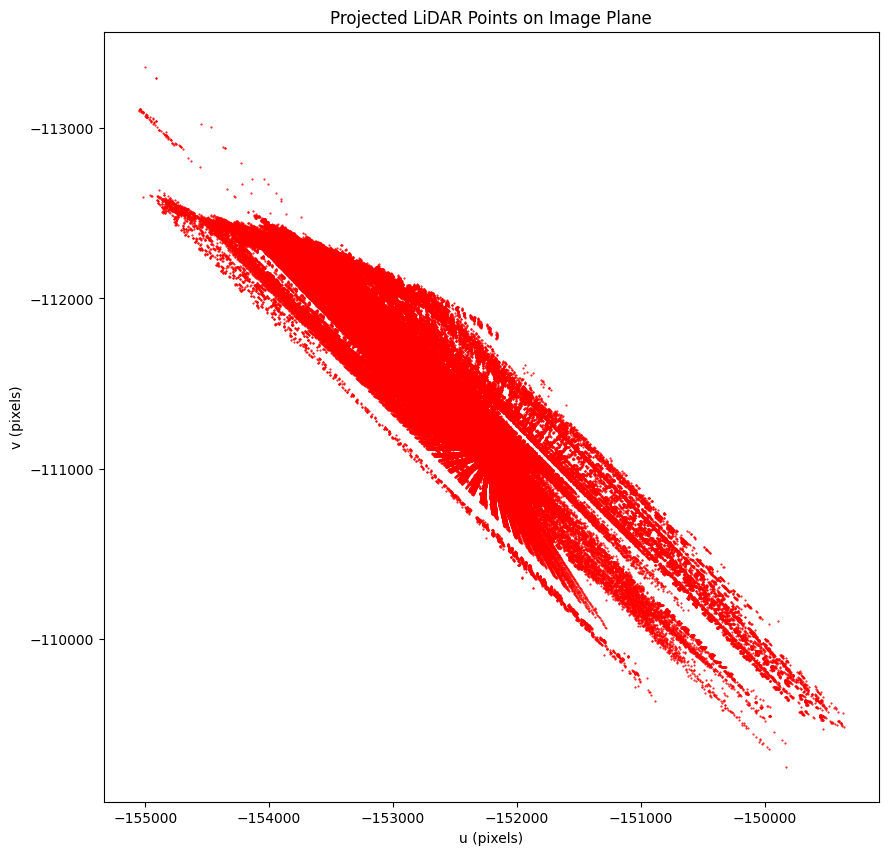

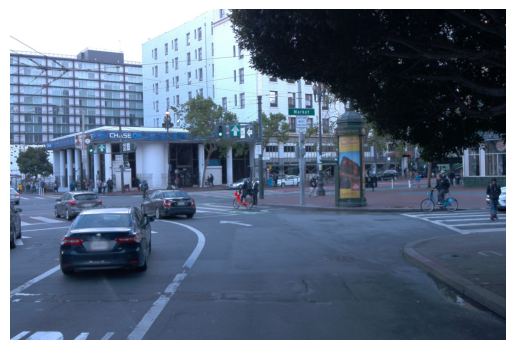

In [6]:
def ReadImageFrame(Frame, CamId):
        image = cv2.imread(f"images/{Frame:03d}_{CamId:01d}.jpg")
        return image

def ReadEgoTransformMatrix(frame):
    data = np.loadtxt(f"ego2world/{frame:03d}.txt", dtype=np.float32)
    if data.size != 16:
        print("Error!!  : Error occured in Reading in Transformation Matrix (the size is not 16)")
    matrix = data.reshape(4, 4)
    return matrix

def ReadCamTransformMatrix(CamId):
    data = np.loadtxt(f"cam2ego/{CamId}.txt", dtype=np.float32)
    if data.size != 16:
        print("Error!!  : Error occured in Reading in Transformation Matrix (the size is not 16)")
    matrix = data.reshape(4, 4)
    return matrix

def TransformThePoints(CloudPoints, TransformMatrix):

    RotationMatrix = TransformMatrix[:3, :3]
    TranslationVector = TransformMatrix[:3, 3]

    # Compute the inverse rotation and translation
    InverseRotationMatrix = np.linalg.inv(RotationMatrix)
    InverseTranslationVector = -np.dot(InverseRotationMatrix, TranslationVector)

    # Apply the inverse transformation
    TransformedPoints = np.dot(CloudPoints - InverseTranslationVector, InverseRotationMatrix.T)

    return TransformedPoints

def ReadIntrinsicMatrix(CamId):
    intrinsic = np.loadtxt(f"intrinsics/{CamId}.txt")
    fx, fy, cx, cy = intrinsic[0], intrinsic[1], intrinsic[2], intrinsic[3]
    IntrinsicMatrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    return IntrinsicMatrix
  
def ProjectToImage(LidarPoints, IntrinsicsMatrix):
    image_points = IntrinsicsMatrix @ LidarPoints.T
    image_points /= image_points[2, :] 
    return image_points[:2, :].T


def visualize_lidar_points(image_points):
    plt.figure(figsize=(10, 10))
    plt.scatter(image_points[:, 0], image_points[:, 1], s=1, c='red', marker='.')
    plt.title('Projected LiDAR Points on Image Plane')
    plt.xlabel('u (pixels)')
    plt.ylabel('v (pixels)')
    plt.gca().invert_yaxis() 
    plt.show()

def visualize_lidar_points_open3d(lidar_points_3d):
    # Convert Waymo LiDAR coordinates to Open3D coordinates
    lidar_points_3d[:, [1, 2]] = lidar_points_3d[:, [2, 1]]

    # Create an Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(lidar_points_3d)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])

def ImgShow(Image):
    plt.imshow(cv2.cvtColor(Image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Main File
TotalFrames = 6
Frame = 2
CamId = 0 

AllPoints = np.vstack(ConcatenatedCloudPoints(TotalFrames))
print("AllPoints = ", AllPoints.shape)

#rotation
TransformMatrix = ReadEgoTransformMatrix(Frame)
# print("TransformMatrix = ", TransformMatrix.shape)
TransformedCloudPoints = TransformThePoints(AllPoints, TransformMatrix)
# print("TransformedCloudPoints = ", TransformedCloudPoints.shape)

CamTransformMatrix = ReadCamTransformMatrix(CamId)
print("CamTransformMatrix = ", CamTransformMatrix.shape)
TransformedCloudPointsinCam = TransformThePoints(TransformedCloudPoints, CamTransformMatrix)
print("TransformedCloudPointsinCam = ", TransformedCloudPointsinCam.shape)

IntrinsicMatrix = ReadIntrinsicMatrix(CamId)
print("IntrinsicMatrix = ", IntrinsicMatrix.shape)
CloudpointsinImage = ProjectToImage(TransformedCloudPointsinCam, IntrinsicMatrix)
print("CloudpointsinImage = ", CloudpointsinImage.shape)

visualize_lidar_points(CloudpointsinImage)
Image = ReadImageFrame(Frame, CamId)
ImgShow(Image)


## Bonus

### `Task 3`. Compute Depth Image from Projected Point Cloud in camera frame (5 points)

**Instructions:**

Using the projected point clouds to camera frame from task 2, visualize the depth image by considering only the z-coordinate of the projected points in the camera frame.

Visualization: Display the depth image for each of the 3 cameras at timesteps `0, 20, and 55` alongside the corresponding RGB image.

In [17]:
##############################################################################
# TODO: TASK 3
##############################################################################

#### Note: You might be asked to show the above results for different timesteps and from one of the 3 cameras during evaluation/viva.

# Q2: Various Representations for Rotations and Gimbal lock (15 points)


#### 2.1 Euler angles (2.5 points)

a. Write a function that returns a rotation matrix given the angles (𝛼, 𝛽, 𝛾) = (2π/5, π/18, π/6) in radians (X-Y-Z). Do not use inbuilt functions.

b. Solve for angles using fsolve from scipy for three initializations of your choice and compare.
$$M(\alpha , \beta ,\gamma)=\left[\begin{array}{rrr}0.26200263 & -0.19674724 &  0.944799  \\0.21984631 &  0.96542533  & 0.14007684 \\
   -0.93969262 & 0.17101007 & 0.29619813\end{array}\right] 
$$

In [7]:
##############################################################################
# TODO: Do tasks described in 2.1 (a)

def RotationMatrix(angles):
    
    theta_x, theta_y, theta_z = angles
    
    # Rotation Matrix around X axis
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(alpha), -np.sin(alpha)],
        [0, np.sin(alpha), np.cos(alpha)]
    ])

   # Rotation Matrix around Y axis
    Ry = np.array([
        [np.cos(beta), 0, np.sin(beta)],
        [0, 1, 0],
        [-np.sin(beta), 0, np.cos(beta)]
    ])

    # Rotation Matrix around Z axis
    Rz = np.array([
        [np.cos(gamma), -np.sin(gamma), 0],
        [np.sin(gamma), np.cos(gamma), 0],
        [0, 0, 1]
    ])

    R = Rz @ Ry @ Rx

    return R

# Angles in Radians
alpha = 2 * np.pi / 5
beta = np.pi / 18
gamma = np.pi / 6

#Angles
Angle  = [alpha, beta, gamma]

#Function Call
R = RotationMatrix(Angle)
print("Rotation Matrix R:")
print(R)


Rotation Matrix R:
[[ 0.85286853 -0.01148507  0.52199939]
 [ 0.49240388  0.35019118 -0.79680898]
 [-0.17364818  0.93660783  0.30432233]]


In [62]:
def Equation(angles, target_matrix):
    R = RotationMatrix(angles)
    return [
        R[0,0] - target_matrix[0,0],
        R[1,1] - target_matrix[1,1],
        R[2,2] - target_matrix[2,2]
    ]

# Given Rotation Matrix
R_given = np.array([
    [ 0.85286853, -0.01148507,  0.52199939],
    [ 0.49240388,  0.35019118, -0.79680898],
    [-0.17364818,  0.93660783,  0.30432233]
])

# Main 
#Initial Angles 
InitialGuess = [0, 0, 0]
solution = fsolve(Equation, InitialGuess, args=(R_given,))
# Convert to degrees
SolutionInDegrees = np.degrees(solution)

# Display
print("\nSolved angles (in degrees):\n", solution)
print("\nSolution in Rotation Matrix : \n", RotationMatrix(solution))
R_solved = RotationMatrix(solution)
print("\nDifference:\n", np.abs(R_solved - R_given))


Solved angles (in degrees):
 [0. 0. 0.]

Solution in Rotation Matrix : 
 [[ 0.85286853 -0.01148507  0.52199939]
 [ 0.49240388  0.35019118 -0.79680898]
 [-0.17364818  0.93660783  0.30432233]]

Difference:
 [[1.95244332e-09 2.19857098e-09 2.62212108e-09]
 [3.49389606e-09 2.78627382e-09 4.57567118e-09]
 [2.33306968e-09 8.00248534e-10 1.87297816e-09]]


#### 2.2 Equivalent angle–axis representation (2.5 points) 

 Write a function to convert equivalent angle–axis representation (with a general axis and angle) to matrix form and vice versa. \
Try it for $\theta = \pi/6$ and axis $K= [1, 2, 3]^T $

In [66]:
##############################################################################
# TODO: Do tasks described in 2.2 

def AngleAxisToMatrix(Angle, Axis):

    # Normalize 
    Axis = np.array(Axis)
    Axis = Axis / np.linalg.norm(Axis)
    
    # Compute the skew-symmetric matrix
    K = np.array([
        [0, -Axis[2], Axis[1]],
        [Axis[2], 0, -Axis[0]],
        [-Axis[1], Axis[0], 0]
    ])
    
    # Rodrigues' rotation formula
    R = np.eye(3) + np.sin(Angle) * K + (1 - np.cos(Angle)) * np.dot(K, K)
    
    return R
def MatrixToAngleAxis(R):
    #  angle
    angle = np.arccos((np.trace(R) - 1) / 2)
    
    # when near 0 
    if np.isclose(angle, 0):
        return 0, np.array([1, 0, 0])  # no rotation
    elif np.isclose(angle, np.pi):
        # when near 180 degrees
        eigenvalues, eigenvectors = np.linalg.eig(R)
        axis = eigenvectors[:, np.isclose(eigenvalues, 1)].real.flatten()
        return np.pi, axis
    
    # finding the axis
    axis = (1 / (2 * np.sin(angle))) * np.array([
        R[2, 1] - R[1, 2],
        R[0, 2] - R[2, 0],
        R[1, 0] - R[0, 1]
    ])
    
    return angle, axis

# To Get matrix from Angle-Axis
theta = np.pi / 6
K = np.array([1, 2, 3])

kNormalized = K / np.linalg.norm(K)

print("Original Angle-Axis representation:")
print(f"Angle: {theta}")
print(f"Normalized Axis: {kNormalized}")

# Function Call
R = AngleAxisToMatrix(theta, K)
print("\nRotation matrix:")
print(R)

# Matrix back to Angle-Axis
Angle, Axis = MatrixToAngleAxis(R)
print("\nConversion to Angle-Axis :")
print(f"Angle: {Angle} radians")
print(f"Normalized Axis: {Axis}")
##############################################################################

Original Angle-Axis representation:
Angle: 0.5235987755982988
Normalized Axis: [0.26726124 0.53452248 0.80178373]

Rotation matrix:
[[ 0.87559502 -0.38175263  0.29597008]
 [ 0.42003109  0.90430386 -0.07621294]
 [-0.2385524   0.19104831  0.95215193]]

Conversion to Angle-Axis :
Angle: 0.5235987755982985 radians
Normalized Axis: [0.26726124 0.53452248 0.80178373]


#### 2.3 Gimbal lock (5 points)

Show an example where a Gimbal lock occurs and visualize the Gimbal lock on the given point cloud, data/toothless.ply. You have to show the above by animation (rotation along each axis one by one).

**Hint:** 
Create 3 disks perpendicular to each other representing axes for local frame of object. Show that in certain configuration, due to use of Euler angles we can lose a degree of freedom. 

Use Open3D's non-blocking visualization and discretize the rotation to simulate the animation. For example, if you want to rotate by 20° around a particular axis, do so in increments of 5° 4 times to make it look like an animation.

In [10]:

# Function to create the rotation matrix
def get_rotation_matrix(x_angle, y_angle, z_angle):
    return o3d.geometry.get_rotation_matrix_from_xyz([x_angle, y_angle, z_angle])

# Create the gimbals (disks representing X, Y, Z axes)
torus_x = o3d.geometry.TriangleMesh.create_torus(torus_radius=2.0, tube_radius=0.1)
torus_x.paint_uniform_color([1.0, 0.0, 0.0])  # Red for X-axis
R_x = get_rotation_matrix(np.pi / 2, 0.0, 0.0)
torus_x.rotate(R_x, center=(0, 0, 0))

torus_y = o3d.geometry.TriangleMesh.create_torus(torus_radius=1.5, tube_radius=0.1)
torus_y.paint_uniform_color([0.0, 1.0, 0.0])  # Green for Y-axis
R_y = get_rotation_matrix(0.0, np.pi / 2, 0.0)
torus_y.rotate(R_y, center=(0, 0, 0))

torus_z = o3d.geometry.TriangleMesh.create_torus(torus_radius=1.0, tube_radius=0.1)
torus_z.paint_uniform_color([0.0, 0.0, 1.0])  # Blue for Z-axis
R_z = get_rotation_matrix(0.0, 0.0, np.pi / 2)
torus_z.rotate(R_z, center=(0, 0, 0))

# Load and prepare the point cloud
point_cloud = o3d.io.read_point_cloud("toothless.ply")
point_cloud.scale(scale=20.0, center=(0, 0, 0))
point_cloud.translate(translation=(0.0, 2.0, 0.0))

# Create the Open3D visualizer
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add the point cloud and gimbals to the visualizer
vis.add_geometry(point_cloud)
vis.add_geometry(torus_x)
vis.add_geometry(torus_y)
vis.add_geometry(torus_z)

# Animation sequence for Gimbal Lock
step = 10
axes = [("y", 90), ("z", 90), ("x", 90)]  # This sequence should lead to gimbal lock
for ax, degree in axes:
    angle = 0
    while angle < degree:
        time.sleep(0.7)  # Control the speed of animation
        
        if ax == "x":
            R = get_rotation_matrix(np.radians(step), 0.0, 0.0)
        elif ax == "y":
            R = get_rotation_matrix(0.0, np.radians(step), 0.0)
        elif ax == "z":
            R = get_rotation_matrix(0.0, 0.0, np.radians(step))
        
        # Rotate the gimbals and point cloud
        torus_x.rotate(R, center=(0, 0, 0))
        torus_y.rotate(R, center=(0, 0, 0))
        torus_z.rotate(R, center=(0, 0, 0))
        point_cloud.rotate(R, center=(0, 0, 0))

        # Update the visualizer
        vis.update_geometry(torus_x)
        vis.update_geometry(torus_y)
        vis.update_geometry(torus_z)
        vis.update_geometry(point_cloud)
        
        vis.poll_events()
        vis.update_renderer()

        angle += step

# Close the visualizer window
vis.destroy_window()


#### 2.4: Quaternions (5 points)

a. Convert a rotation matrix to quaternion and vice versa. Do not use inbuilt libraries for this question.

b. Perform matrix multiplication of two 3×3 rotation matrices and perform the same transformation in the quaternion space. Verify if the final transformation obtained in both cases is the same.

c. Try to interpolate any given model between two rotation matrices and visualize!

In [89]:
##############################################################################
# TODO: Do tasks described in 2.4 (a)


def RotationMatrixToQuaternions(R):
    q = np.zeros(4)
    trace = np.trace(R)
    
    if trace > 0:
        S = np.sqrt(trace + 1.0) * 2  # S=4*qw
        q[0] = 0.25 * S
        q[1] = (R[2, 1] - R[1, 2]) / S
        q[2] = (R[0, 2] - R[2, 0]) / S
        q[3] = (R[1, 0] - R[0, 1]) / S

    elif (R[0, 0] > R[1, 1]) and (R[0, 0] > R[2, 2]):
        S = np.sqrt(1.0 + R[0, 0] - R[1, 1] - R[2, 2]) * 2  # S=4*qx
        q[0] = (R[2, 1] - R[1, 2]) / S
        q[1] = 0.25 * S
        q[2] = (R[0, 1] + R[1, 0]) / S
        q[3] = (R[0, 2] + R[2, 0]) / S

    elif R[1, 1] > R[2, 2]:
        S = np.sqrt(1.0 + R[1, 1] - R[0, 0] - R[2, 2]) * 2  # S=4*qy
        q[0] = (R[0, 2] - R[2, 0]) / S
        q[1] = (R[0, 1] + R[1, 0]) / S
        q[2] = 0.25 * S
        q[3] = (R[1, 2] + R[2, 1]) / S

    else:
        S = np.sqrt(1.0 + R[2, 2] - R[0, 0] - R[1, 1]) * 2  # S=4*qz
        q[0] = (R[1, 0] - R[0, 1]) / S
        q[1] = (R[0, 2] + R[2, 0]) / S
        q[2] = (R[1, 2] + R[2, 1]) / S
        q[3] = 0.25 * S
    
    return q

# Example 
R = np.array([[0.866, -0.5, 0],
              [0.5, 0.866, 0],
              [0, 0, 1]])
q = RotationMatrixToQuaternions(R)
print("Quaternion:", q)


def QuaternionsToRotationMatrix(q):
    qw, qx, qy, qz = q
    R = np.array([[1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
                  [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
                  [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]])
    return R

# Example 
R_converted = QuaternionsToRotationMatrix(q)
print("Rotation Matrix:\n", R_converted)
##############################################################################

Quaternion: [0.96591925 0.         0.         0.25882081]
Rotation Matrix:
 [[ 0.86602358 -0.5         0.        ]
 [ 0.5         0.86602358  0.        ]
 [ 0.          0.          1.        ]]


In [79]:
##############################################################################
# TODO: Do tasks described in 2.4 (b)


def MultRotationMatrices(R1, R2):
    return np.dot(R1, R2)

# Example usage
R1 = np.array([[0.866, -0.5, 0],
               [0.5, 0.866, 0],
               [0, 0, 1]])
R2 = np.array([[1, 0, 0],
               [0, 0.866, -0.5],
               [0, 0.5, 0.866]])
RProduct = MultRotationMatrices(R1, R2)
print("Mult of Rotation Matrices:\n", RProduct)

def MultQuaternions(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

# Example usage
q1 = RotationMatrixToQuaternions(R1)
q2 = RotationMatrixToQuaternions(R2)
q_product = MultQuaternions(q1, q2)
print("\n Mult of Quaternions:", q_product)

# Convert quaternion product back to rotation matrix
R_from_quaternion_product = QuaternionsToRotationMatrix(q_product)
print("\n Rotation Matrix from Quaternion Product: \n", R_from_quaternion_product)
print("\n Difference betwen Rotation Matrix and Quaternion Product: \n", RProduct -  R_from_quaternion_product)

##############################################################################

Mult of Rotation Matrices:
 [[ 0.866    -0.433     0.25    ]
 [ 0.5       0.749956 -0.433   ]
 [ 0.        0.5       0.866   ]]

 Mult of Quaternions: [0.933      0.25       0.06698821 0.25      ]

 Rotation Matrix from Quaternion Product: 
 [[ 0.86602516 -0.43300589  0.25      ]
 [ 0.49999411  0.75       -0.43300589]
 [ 0.          0.49999411  0.86602516]]

 Difference betwen Rotation Matrix and Quaternion Product: 
 [[-2.51594219e-05  5.89496249e-06  0.00000000e+00]
 [ 5.89496249e-06 -4.40000000e-05  5.89496249e-06]
 [ 0.00000000e+00  5.89496249e-06 -2.51594219e-05]]


In [86]:
##############################################################################
# TODO: Do tasks described in 2.4 (c)


# Function to interpolate between two rotation matrices
def InterpolationRotationMatrices(R1, R2, t):
    return (1 - t) * R1 + t * R2

# First Rotation matrix 
R1 = np.array([[0.866, -0.5, 0],
               [0.5, 0.866, 0],
               [0, 0, 1]])

# Second Rotation matrix
R2 = np.array([[1, 0, 0],
               [0, 0.866, -0.5],
               [0, 0.5, 0.866]])

# using toothless point cloud
pcd = o3d.io.read_point_cloud("toothless.ply")

# Seeing the visualization
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)

# Interpolation 
#                      start, step, end
t_values = np.linspace(0, 0.5, 10)

for t in t_values:
    
    #Function Call
    R_interp = InterpolationRotationMatrices(R1, R2, t)
    pcd.rotate(R_interp, center=(0, 0, 0))
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.1)

vis.run()
vis.destroy_window()

##############################################################################


# Q3: Interpolation between transformations (15 points)

Given 2 random transformation matrices, interpolate the given point cloud **toothless.ply** from `T2` to `T1` and visualize it.

We will use the `generateTransformation()` function to generate a random Transformation matrix. You can write your own `generateTransformation()` function for testing, but we will replace it with our own so make sure that your code works for general cases.

Ensure that your visualization shows the starting and ending configurations during interpolation.

Your final output should look something like this:
![Visualization](./out.gif)

In [11]:
def generate_transformation():
    """Generate a random 4x4 transformation matrix."""
    R = o3d.geometry.get_rotation_matrix_from_xyz(np.random.rand(3) * 2 * np.pi)
    T = np.random.rand(3) * 10  # Random translation up to 10 units
    return np.vstack((np.hstack((R, T.reshape(-1, 1))), [0, 0, 0, 1]))

In [14]:
def generate_transformation():
    """Generate a random 4x4 transformation matrix."""
    R = o3d.geometry.get_rotation_matrix_from_xyz(np.random.rand(3) * 2 * np.pi)
    T = np.random.rand(3) * 10  # Random translation up to 10 units
    transformation = np.vstack((np.hstack((R, T.reshape(-1, 1))), [0, 0, 0, 1]))
    return transformation

def interpolate_transformations(T1, T2, num_steps):
    """Interpolate between two transformations."""
    interpolated_transforms = []
    for t in np.linspace(0, 1, num_steps):
        # Ensure T1 and T2 are 2D arrays with shape (4, 4)
        if T1.shape != (4, 4) or T2.shape != (4, 4):
            raise ValueError("Transformation matrices must be of shape (4, 4)")

        R1, T1_part = T1[:3, :3], T1[:3, 3]
        R2, T2_part = T2[:3, :3], T2[:3, 3]
        
        # Interpolate rotation matrices using slerp for better results
        R = R1 * (1 - t) + R2 * t
        
        # Interpolate translations
        T = T1_part * (1 - t) + T2_part * t
        
        # Combine rotation and translation into a 4x4 transformation matrix
        transform = np.vstack((np.hstack((R, T.reshape(-1, 1))), [0, 0, 0, 1]))
        interpolated_transforms.append(transform)
    
    return interpolated_transforms

def apply_transformation(pcd, transformation):
    """Apply a transformation matrix to a point cloud."""
    pcd.transform(transformation)

def create_point_cloud_copy(pcd):
    """Create a new PointCloud object with the same points and colors."""
    new_pcd = o3d.geometry.PointCloud()
    new_pcd.points = pcd.points
    new_pcd.colors = pcd.colors
    return new_pcd

# Generate two random transformations
T1 = generate_transformation()
T2 = generate_transformation()

# Ensure that T1 and T2 are of shape (4, 4)
print("T1 shape:", T1.shape)
print("T2 shape:", T2.shape)

# Load the point cloud
point_cloud = o3d.io.read_point_cloud("toothless.ply")
point_cloud.scale(scale=20.0, center=(0, 0, 0))
point_cloud.translate(translation=(0.0, 2.0, 0.0))

# Create visualizer
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add the point cloud to the visualizer
vis.add_geometry(point_cloud)

# Interpolate between T1 and T2
num_steps = 30
interpolated_transforms = interpolate_transformations(T1, T2, num_steps)

# Visualize interpolation
for transform in interpolated_transforms:
    point_cloud_copy = create_point_cloud_copy(point_cloud)  # Create a new copy of the point cloud
    apply_transformation(point_cloud_copy, transform)
    
    vis.clear_geometries()
    vis.add_geometry(point_cloud_copy)
    
    # Visualize the starting and ending configurations
    vis.update_geometry(point_cloud_copy)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.1)  # Adjust this for animation speed

# Close the visualizer window
vis.destroy_window()


T1 shape: (4, 4)
T2 shape: (4, 4)


## Bonus (5 points)

In [16]:
import numpy as np
import open3d as o3d
import time
from scipy.spatial.transform import Rotation as R

def generate_transformation():
    """Generate a random 4x4 transformation matrix."""
    rotation = R.from_euler('xyz', np.random.rand(3) * 360, degrees=True)
    R_matrix = rotation.as_matrix()
    T = np.random.rand(3) * 10  # Random translation up to 10 units
    transformation = np.vstack((np.hstack((R_matrix, T.reshape(-1, 1))), [0, 0, 0, 1]))
    return transformation

def slerp(q1, q2, t):
    """Perform spherical linear interpolation between two quaternions."""
    # Compute the dot product to determine the angle between the quaternions
    dot = np.dot(q1, q2)
    
    # Adjust for the case when the dot product is negative
    if dot < 0.0:
        q2 = -q2
        dot = -dot
    
    # Clamp dot to the range [0, 1] to avoid numerical issues
    dot = np.clip(dot, 0.0, 1.0)
    
    # Compute the interpolation coefficients
    theta_0 = np.arccos(dot)
    theta = theta_0 * t
    q2 = q2 - q1 * dot
    q2 = q2 / np.linalg.norm(q2)
    
    # Compute the interpolated quaternion
    q_interp = q1 * np.cos(theta) + q2 * np.sin(theta)
    q_interp = q_interp / np.linalg.norm(q_interp)
    
    return q_interp

def interpolate_transformations(T1, T2, num_steps):
    """Interpolate between two transformations."""
    interpolated_transforms = []
    R1, T1_part = T1[:3, :3], T1[:3, 3]
    R2, T2_part = T2[:3, :3], T2[:3, 3]
    
    # Convert rotation matrices to quaternions
    q1 = R.from_matrix(R1).as_quat()
    q2 = R.from_matrix(R2).as_quat()
    
    for t in np.linspace(0, 1, num_steps):
        # Interpolate rotation quaternions using SLERP
        q_interp = slerp(q1, q2, t)
        R_interp = R.from_quat(q_interp).as_matrix()
        
        # Interpolate translations
        T_interp = T1_part * (1 - t) + T2_part * t
        
        # Combine rotation and translation into a 4x4 transformation matrix
        transform = np.vstack((np.hstack((R_interp, T_interp.reshape(-1, 1))), [0, 0, 0, 1]))
        interpolated_transforms.append(transform)
    
    return interpolated_transforms

def apply_transformation(pcd, transformation):
    """Apply a transformation matrix to a point cloud."""
    pcd.transform(transformation)

def create_point_cloud_copy(pcd):
    """Create a new PointCloud object with the same points and colors."""
    new_pcd = o3d.geometry.PointCloud()
    new_pcd.points = pcd.points
    new_pcd.colors = pcd.colors
    return new_pcd

# Generate two random transformations
T1 = generate_transformation()
T2 = generate_transformation()

# Ensure that T1 and T2 are of shape (4, 4)
print("T1 shape:", T1.shape)
print("T2 shape:", T2.shape)

# Load the point cloud
point_cloud = o3d.io.read_point_cloud("toothless.ply")
point_cloud.scale(scale=20.0, center=(0, 0, 0))
point_cloud.translate(translation=(0.0, 2.0, 0.0))

# Create visualizer
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add the point cloud to the visualizer
vis.add_geometry(point_cloud)

# Interpolate between T1 and T2
num_steps = 30
interpolated_transforms = interpolate_transformations(T1, T2, num_steps)

# Visualize interpolation
for transform in interpolated_transforms:
    point_cloud_copy = create_point_cloud_copy(point_cloud)  # Create a new copy of the point cloud
    apply_transformation(point_cloud_copy, transform)
    
    vis.clear_geometries()
    vis.add_geometry(point_cloud_copy)
    
    # Visualize the starting and ending configurations
    vis.update_geometry(point_cloud_copy)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.1)  # Adjust this for animation speed

# Close the visualizer window
vis.destroy_window()


T1 shape: (4, 4)
T2 shape: (4, 4)


#### References: https://en.wikipedia.org/wiki/Slerp